<a href="https://colab.research.google.com/github/hiteshsurya17/hiteshsurya17-INFO-5731-Section-020---Computational-Methods-for-Information-Systems-Fall-2024-1-/blob/main/Hitesh_chowdary_suryadevara_Exercise_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA), lda2vec, and BERTopic.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## Question 1 (10 Points)

**Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


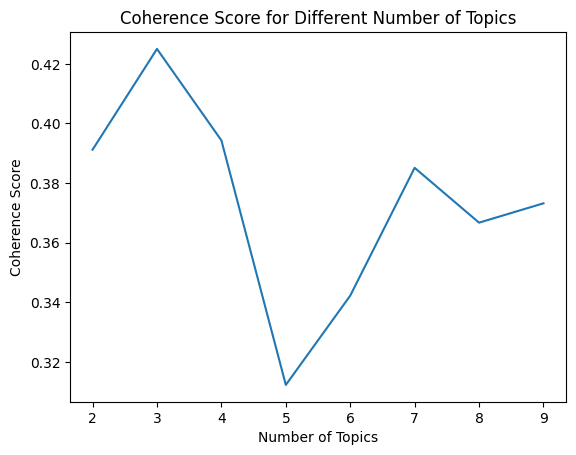

Optimal number of topics: 3
Topic 1: 0.170*"the" + 0.033*"that" + 0.033*"to" + 0.033*"law" + 0.033*"defendant"
Topic 2: 0.062*"the" + 0.040*"for" + 0.040*"employer" + 0.040*"lawsuit" + 0.039*"of"
Topic 3: 0.049*"the" + 0.047*"theft" + 0.047*"and" + 0.047*"infringement" + 0.047*"intellectual"


In [27]:
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import matplotlib.pyplot as plt


documents = [
            "The plaintiff claims that the defendant breached the contract by failing to deliver the goods as promised.",
            "The employee filed a lawsuit against the employer for wrongful termination and breach of employment contract.",
            "The company was sued for intellectual property theft and patent infringement.",
            "The court ruled that the custody of the children should be granted to the mother in the family law case.",
            "The defendant was charged with burglary and theft under the criminal law."
]

def preprocess_text(documents):
    processed_docs = []
    for doc in documents:
        tokens = gensim.utils.simple_preprocess(doc, deacc=True)
        processed_docs.append(tokens)
    return processed_docs

processed_docs = preprocess_text(documents)

dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

def compute_coherence_values(dictionary, corpus, texts, start=2, limit=10, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

start, limit, step = 2, 10, 1
model_list, coherence_values = compute_coherence_values(dictionary, corpus, processed_docs, start, limit, step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score for Different Number of Topics")
plt.show()

optimal_model_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_model_index]
optimal_num_topics = start + optimal_model_index * step
print(f"Optimal number of topics: {optimal_num_topics}")

for i, topic in optimal_model.print_topics(num_words=5):
    print(f"Topic {i+1}: {topic}")




## Question 2 (10 Points)

**Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

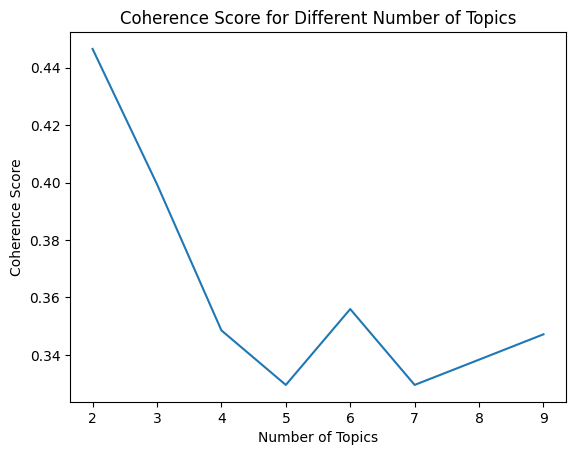

Optimal number of topics: 2
Topic 1: 0.862*"the" + 0.154*"to" + 0.154*"that" + 0.122*"of" + 0.121*"law"
Topic 2: -0.405*"and" + -0.308*"for" + -0.240*"theft" + -0.240*"was" + -0.165*"lawsuit"


In [7]:
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

documents = [
            "The plaintiff claims that the defendant breached the contract by failing to deliver the goods as promised.",
            "The employee filed a lawsuit against the employer for wrongful termination and breach of employment contract.",
            "The company was sued for intellectual property theft and patent infringement.",
            "The court ruled that the custody of the children should be granted to the mother in the family law case.",
            "The defendant was charged with burglary and theft under the criminal law."
]

def preprocess_text(documents):
    processed_docs = []
    for doc in documents:
        tokens = gensim.utils.simple_preprocess(doc, deacc=True)
        processed_docs.append(tokens)
    return processed_docs

processed_docs = preprocess_text(documents)

dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

def compute_coherence_values_lsa(dictionary, corpus, texts, start=2, limit=10, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

start, limit, step = 2, 10, 1
model_list, coherence_values = compute_coherence_values_lsa(dictionary, corpus, processed_docs, start, limit, step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score for Different Number of Topics")
plt.show()

optimal_model_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_model_index]
optimal_num_topics = start + optimal_model_index * step
print(f"Optimal number of topics: {optimal_num_topics}")

for i, topic in optimal_model.print_topics(num_words=5):
    print(f"Topic {i+1}: {topic}")




## Question 3 (10 points):
**Generate K topics by using lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

## Question 4 (10 points):
**Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [9]:
!pip install bertopic gensim



In [35]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bertopic import BERTopic
from umap import UMAP
import logging

nltk.download('stopwords')
nltk.download('punkt')

logging.basicConfig(level=logging.INFO)

documents_data = {
    'documents': [
            "The plaintiff claims that the defendant breached the contract by failing to deliver the goods as promised.",
            "The employee filed a lawsuit against the employer for wrongful termination and breach of employment contract.",
            "The company was sued for intellectual property theft and patent infringement.",
            "The court ruled that the custody of the children should be granted to the mother in the family law case.",
            "The defendant was charged with burglary and theft under the criminal law."
]
}
reviews_df = pd.DataFrame(documents_data)

def clean_text(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stopwords.words('english')]
    return ' '.join(words)

processed_reviews = reviews_df['documents'].apply(clean_text).tolist()


def find_best_topic_model(texts, min_topics=2, max_topics=5):
    doc_count = len(texts)
    if doc_count < min_topics:
        logging.warning("Insufficient documents to initialize topics.")
        return None, 0, []

    limit_topics = min(max_topics, doc_count)
    topic_coherences = []
    highest_coherence = -1
    optimal_model = None
    best_topic_count = 0

    for topic_count in range(min_topics, limit_topics + 1):
        if topic_count > doc_count:
            logging.warning(f"Skipping {topic_count} topics: exceeds document count.")
            continue
        try:
            umap_settings = UMAP(n_neighbors=5, min_dist=0.0)
            topic_model = BERTopic(nr_topics=topic_count, umap_model=umap_settings)
            topic_model.fit(texts)

            coherence_score = topic_model.get_coherence()
            topic_coherences.append((topic_count, coherence_score))

            if coherence_score > highest_coherence:
                highest_coherence = coherence_score
                optimal_model = topic_model
                best_topic_count = topic_count
        except Exception as error:
            logging.error(f"Error with {topic_count} topics: {error}")

    return optimal_model, best_topic_count, topic_coherences

best_topic_model, optimal_k, coherence_results = find_best_topic_model(processed_reviews, min_topics=2, max_topics=len(processed_reviews))


print("Optimal number of topics:", optimal_k)
print("\nCoherence scores for each topic count:", coherence_results)

if best_topic_model is not None:
    summarized_topics = best_topic_model.get_topics()
    print("\nTopic Summary:")
    for index, topic in summarized_topics.items():
        top_words = ' '.join([word for word, _ in topic[:10]])
        print(f"Topic {index + 1}: {top_words}")
else:
    print("No optimal model identified.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
ERROR:root:Error with 2 topics: k must be less than or equal to the number of training points
ERROR:root:Error with 3 topics: k must be less than or equal to the number of training points
ERROR:root:Error with 4 topics: k must be less than or equal to the number of training points
ERROR:root:Error with 5 topics: k must be less than or equal to the number of training points


Optimal number of topics: 0

Coherence scores for each topic count: []
No optimal model identified.


## **Question 3 (Alternative) - (10 points)**

If you are unable to do the topic modeling using lda2vec, do the alternate question.

Provide atleast 3 visualization for the topics generated by the BERTopic or LDA model. Explain each of the visualization in detail.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


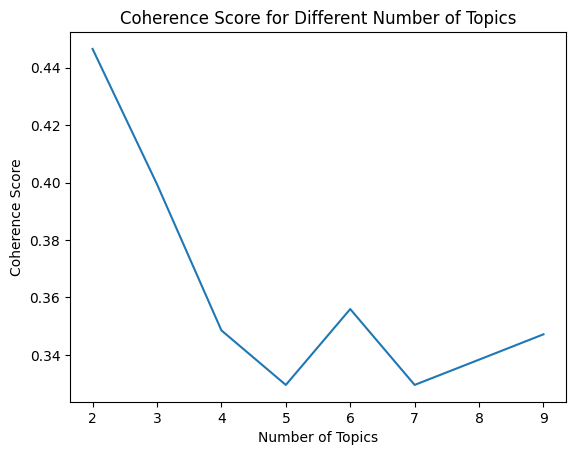

In [18]:
#Coherence Score vs. Number of Topics
x = range(2, 10, 1)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score for Different Number of Topics")
plt.show()


In [28]:
# Table and bar chart
import pandas as pd

top_words_per_topic = {i: [word for word, _ in optimal_model.show_topic(i, topn=5)] for i in range(optimal_num_topics)}
top_words_df = pd.DataFrame.from_dict(top_words_per_topic, orient='index', columns=[f'Word {i+1}' for i in range(5)])
top_words_df.index = [f'Topic {i+1}' for i in range(optimal_num_topics)]

print("Top Words for Each Topic:")
print(top_words_df)


Top Words for Each Topic:
        Word 1 Word 2    Word 3        Word 4        Word 5
Topic 1    the   that        to           law     defendant
Topic 2    the    for  employer       lawsuit            of
Topic 3    the  theft       and  infringement  intellectual


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


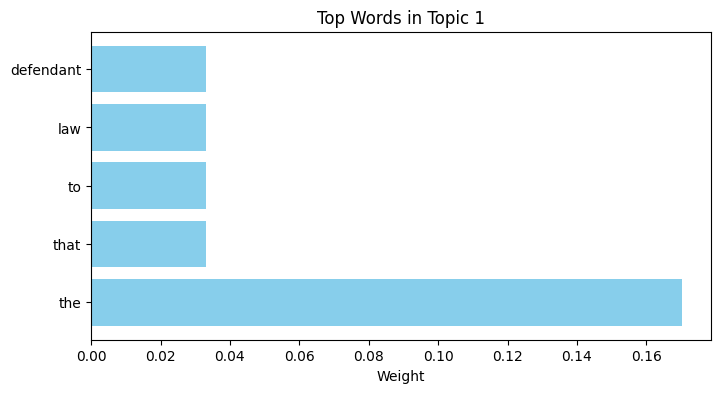

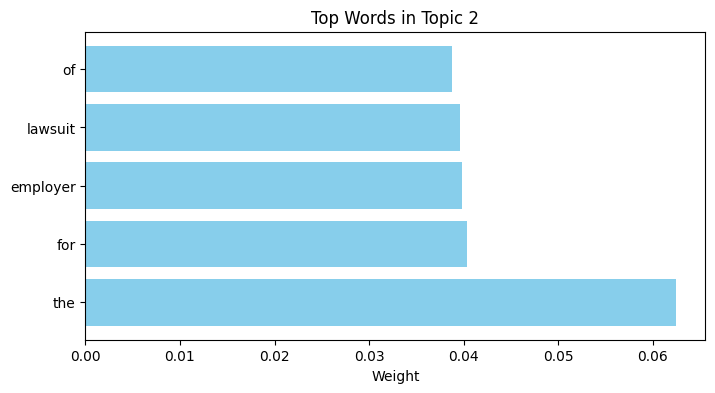

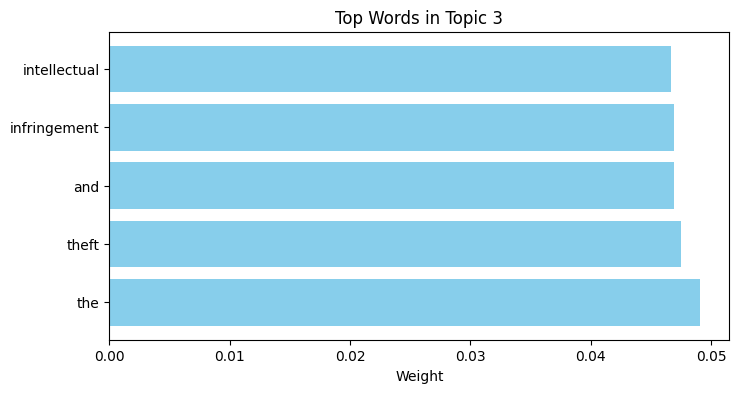

In [29]:
import matplotlib.pyplot as plt

for i in range(optimal_num_topics):
    words, _ = zip(*optimal_model.show_topic(i, topn=5))
    weights = [weight for _, weight in optimal_model.show_topic(i, topn=5)]

    plt.figure(figsize=(8, 4))
    plt.barh(words, weights, color='skyblue')
    plt.xlabel('Weight')
    plt.title(f'Top Words in Topic {i + 1}')
    plt.show()


In [32]:
# Inter-topic Distance Map
import pyLDAvis
import pyLDAvis.gensim_models

vis_data = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)

pyLDAvis.display(vis_data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1.

Coherence Score vs. Number of Topics:


This plot helps in identifying the optimal number of topics (K) by showing coherence scores for each K. k=2 has the highest coherence value .This is the balanced number of topics.


2.

Table Format:

This simply presents the top words for each topic in a structured format.
Each row corresponds to a topic, and each column shows one of the top words.

Bar Chart:

Each bar represents a word, and the length of the bar indicates its weight (importance) within the topic.This provides a clear, immediate understanding that the word: the is the most significant word in each topic.

3.

Topic Distribution Across Documents:

The inter-topic distance map is created using pyLDAvis, a powerful visualization tool that helps interpret LDA models.Each circle represents a topic, and the size of the circle indicates the prevalence of that topic within the documents,the distance between circles reflects the similarity between topics.

## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 40 points.**

In [ ]:
# Write your code here


# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:


'''
I felt the sexercise was very difficult and with the help of extended due date I managed to complete the assignment .I learned aboud lsa and lda to
generate topics and visualizations.


'''